In [107]:
import os
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Convolution2D,MaxPooling2D,Flatten,BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix

from mpl_toolkits.axes_grid1 import ImageGrid

import itertools

# Utility
import os
import numpy as np
import itertools
import random
from collections import Counter
from glob import iglob

# Import OpenCV
import cv2

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
# https://github.com/abhinav23dixit/Waste-Classification

# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/

# plot image
# https://www.tensorflow.org/tutorials/images/classification
# https://github.com/msminhas93/KerasImageDatagenTutorial/blob/master/DataGenTutorial.ipynb

# confusion matrix
# https://www.kaggle.com/paoloripamonti/derma-diseases

In [4]:
base_dir = 'Recycling_Data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

In [5]:
print('total training images:', len(os.listdir(train_dir)))
print('total testing images:', len(os.listdir(test_dir)))
print('total validation images:', len(os.listdir(validation_dir)))

total training images: 6
total testing images: 636
total validation images: 6


In [6]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

In [7]:
# fig = plt.gcf()
# fig.set_size_inches(ncols * 4, nrows * 4)

# pic_index += 8
# next_cat_pix = [os.path.join(train_cats_dir, fname) 
#                 for fname in train_cat_fnames[pic_index-8:pic_index]]
# next_dog_pix = [os.path.join(train_dogs_dir, fname) 
#                 for fname in train_dog_fnames[pic_index-8:pic_index]]

# for i, img_path in enumerate(next_cat_pix+next_dog_pix):
#   # Set up subplot; subplot indices start at 1
#   sp = plt.subplot(nrows, ncols, i + 1)
#   sp.axis('Off') # Don't show axes (or gridlines)

#   img = mpimg.imread(img_path)
#   plt.imshow(img)

# plt.show()

In [8]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(256,256),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(256,256),
        batch_size=20,
        class_mode='categorical')

Found 1262 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


In [9]:
# classes training

train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [10]:
# classes validation

validation_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [11]:
validation_generator.filenames[0:5]

['cardboard\\cardboard100.jpg',
 'cardboard\\cardboard105.jpg',
 'cardboard\\cardboard107.jpg',
 'cardboard\\cardboard112.jpg',
 'cardboard\\cardboard123.jpg']

In [12]:
sample_training_images, _ = next(validation_generator)

In [13]:
class_mapping = {v:k for k,v in validation_generator.class_indices.items()}

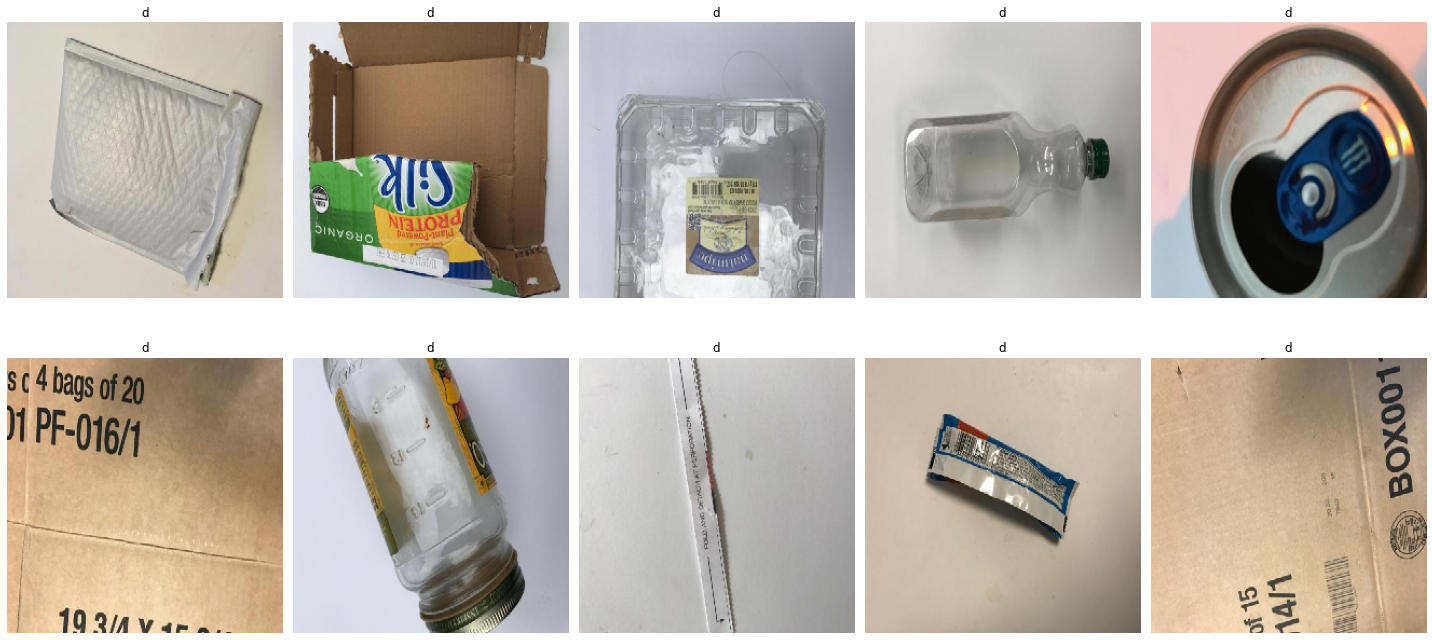

In [14]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(20,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title('d')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:10])

In [15]:
class_mapping = {v:k for k,v in validation_generator.class_indices.items()}

x,y = next(validation_generator)
print('x: ',type(x))
print('y: ',type(y))
print('x: ',x.shape)
print('y: ',y.shape)

x:  <class 'numpy.ndarray'>
y:  <class 'numpy.ndarray'>
x:  (20, 256, 256, 3)
y:  (20, 6)


In [16]:
print('Number of samples: ',validation_generator.samples)
print('Number of classes: ',len(validation_generator.class_indices))
print('Number of samples per class:', int(validation_generator.samples/len(validation_generator.class_indices)))

Number of samples:  630
Number of classes:  6
Number of samples per class: 105


In [17]:
import numpy as np
y_int = np.argmax(y,axis=-1)

In [18]:
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

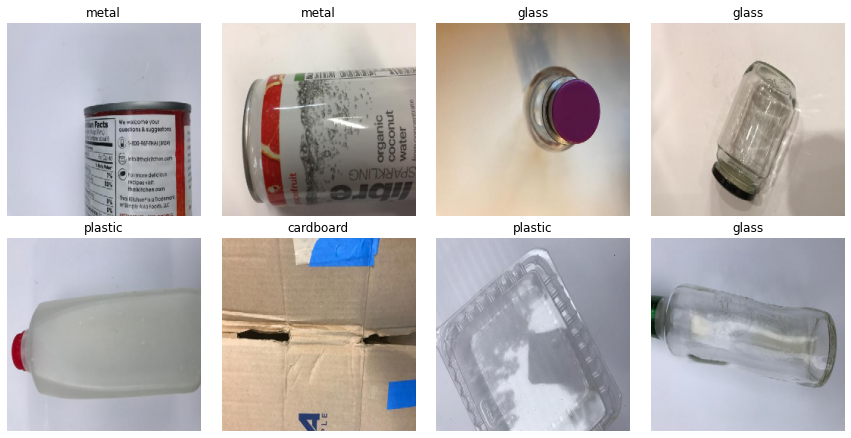

In [21]:
show_grid(x,2,4,label_list=y_int,show_labels=True,figsize=(15,10))

In [22]:
classifier = Sequential()

classifier.add(Convolution2D(input_shape=(256,256,3),filters=96,kernel_size=(11,11),strides=4,activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Convolution2D(filters=256,kernel_size=(5,5),activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Convolution2D(filters=384,kernel_size=(3,3),activation = 'relu'))
classifier.add(Convolution2D(filters=384,kernel_size=(3,3),activation = 'relu'))
classifier.add(Convolution2D(filters=256,kernel_size=(3,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))

In [23]:
classifier.add(Flatten())

classifier.add(Dense(output_dim=2048,activation='relu'))
classifier.add(Dense(output_dim=2048,activation='relu'))
classifier.add(Dense(output_dim=6,activation='softmax'))

classifier.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [25]:
history=classifier.fit_generator(train_generator,
                    steps_per_epoch=100,
                    epochs=3,
                    validation_data=validation_generator,
                    validation_steps=228)

Epoch 1/3
100/100 [==============================] - 200s 2s/step - loss: 1.5189 - accuracy: 0.3936 - val_loss: 1.6489 - val_accuracy: 0.3886
Epoch 2/3
100/100 [==============================] - 200s 2s/step - loss: 1.4941 - accuracy: 0.4092 - val_loss: 1.5479 - val_accuracy: 0.3788
Epoch 3/3
100/100 [==============================] - 213s 2s/step - loss: 1.4411 - accuracy: 0.4445 - val_loss: 1.8220 - val_accuracy: 0.3452


In [26]:
# Performance matrix 
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,val_loss,val_accuracy,loss,accuracy,epoch
0,1.648938,0.388641,1.518700,0.393585,0
1,1.547898,0.378842,1.501748,0.409183,1
2,1.822010,0.345212,1.443615,0.444501,2


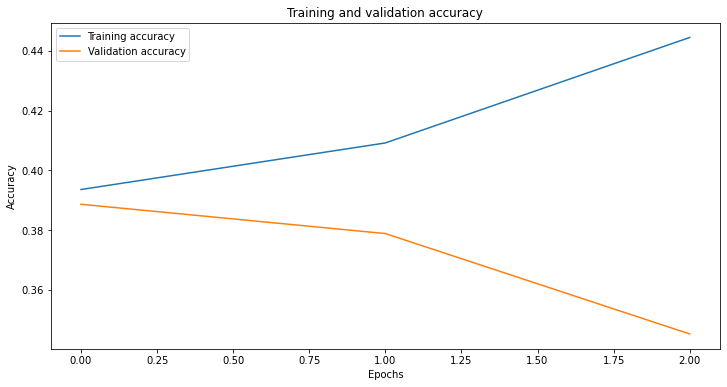

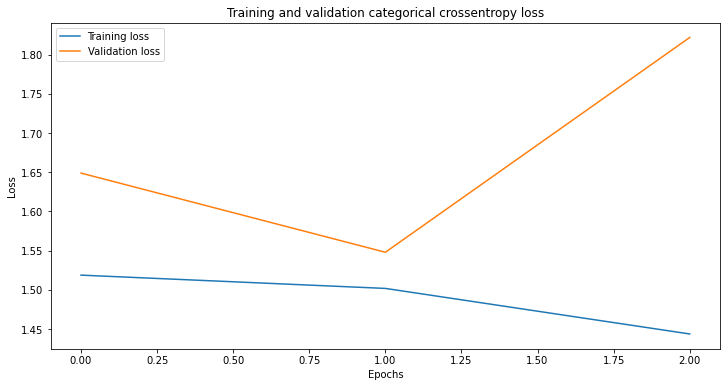

In [27]:
# Graph: Training and Validation dataset performance

plt.rcParams['figure.figsize'] = (12.0, 6.0)

def plot_cnn_performance(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Training accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Validation accuracy')
    plt.legend()
  

    plt.figure()
    plt.xlabel('Epochs')
    plt.title('Training and validation categorical crossentropy loss')
    plt.plot(hist['epoch'], hist['loss'],label='Training loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_cnn_performance(history)

In [28]:
#Evaluate model performance on validation dataset

score = classifier.evaluate_generator(validation_generator)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 2.003342866897583
Validation accuracy: 0.34285715222358704


In [29]:
#Evaluate model performance on training dataset

score = classifier.evaluate_generator(train_generator)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 1.6818645000457764
Train accuracy: 0.3835182189941406


In [31]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        directory=test_dir,  # This is the source directory for training images
        target_size=(256,256),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        shuffle=False)

# Flow training images in batches of 20 using train_datagen generator
# test_generator = test_datagen.flow_from_directory(
#         directory=test_dir,  # This is the source directory for training images
#         target_size=(256,256),  # All images will be resized to 150x150
#         batch_size=1,
#         # Since we use binary_crossentropy loss, we need binary labels
#         class_mode=None,
#         shuffle=False,
#         seed=42)
 
    
# waste_types = ['cardboard','glass','metal','paper','plastic','trash']
# test_generator = test_datagen.flow_from_directory(
#         directory=test_dir,  # This is the source directory for training images
#         target_size=(256,256),  # All images will be resized to 150x150
#         batch_size=10,
#         # Since we use binary_crossentropy loss, we need binary labels
#         classes=waste_types,
#         shuffle=False,
#         seed=42)

Found 1262 images belonging to 6 classes.


In [32]:
loss, accuracy = classifier.evaluate_generator(test_generator,
            steps=test_generator.samples//test_generator.batch_size)

In [33]:
print("Accuracy: %f\nLoss: %f" % (accuracy,loss))

Accuracy: 0.384127
Loss: 2.153131


In [95]:
# Y_pred = classifier.predict_generator(test_generator, steps = len(test_generator.filenames))

# Y_pred = classifier.predict_generator(test_generator,verbose=1, steps=test_generator.samples//test_generator.batch_size)

predict=classifier.predict_generator(test_generator)

In [97]:
y_pred = np.argmax(predict, axis=1)

In [98]:
len(y_pred)

1262

In [88]:
len(train_generator.classes)

1262

In [99]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)
cnf_matrix

array([[ 60,  69,   8,  56,   2,   6],
       [  4, 169,   7,  43,  23,   4],
       [ 11, 131,  24,  24,  12,   3],
       [ 12,  82,  17, 168,  15,   3],
       [  3,  85,  21,  70,  59,   3],
       [  2,  48,   0,   8,   6,   4]], dtype=int64)

In [100]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

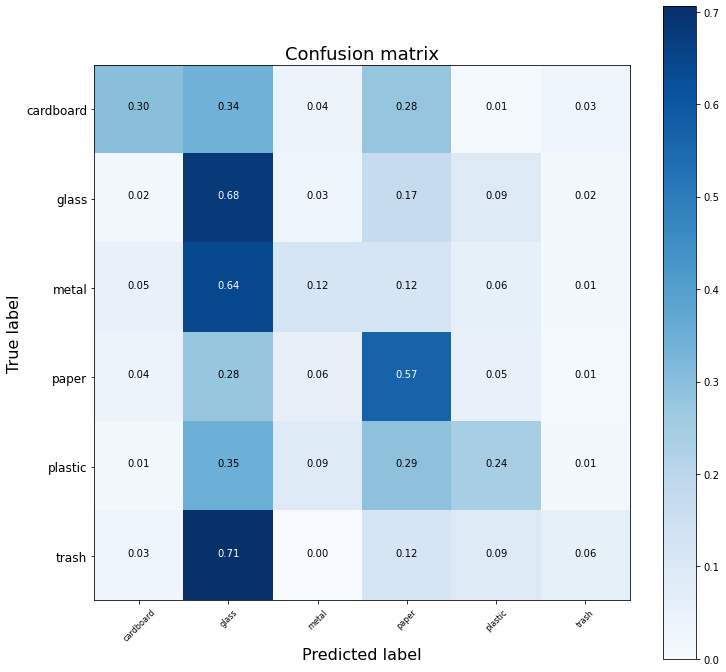

In [101]:
plot_confusion_matrix(cnf_matrix, list(class_mapping.values()))

In [104]:
print(classification_report(test_generator.classes, y_pred, target_names=list(class_mapping.values())))

              precision    recall  f1-score   support

   cardboard       0.65      0.30      0.41       201
       glass       0.29      0.68      0.41       250
       metal       0.31      0.12      0.17       205
       paper       0.46      0.57      0.50       297
     plastic       0.50      0.24      0.33       241
       trash       0.17      0.06      0.09        68

    accuracy                           0.38      1262
   macro avg       0.40      0.33      0.32      1262
weighted avg       0.42      0.38      0.36      1262



In [124]:
# ResNet50 image size
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3)

In [127]:

def load_image(filename):
    img = cv2.imread(os.path.join("Recycling_Data\\test\\", filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = classifier.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {class_mapping[class_idx]: probabilities[class_idx]}

SOURCE: class: paper, file: paper\paper399.jpg
PREDICTED: class: glass, confidence: 0.438507


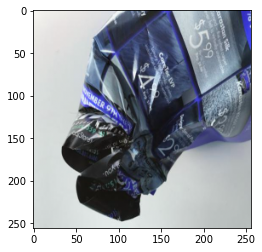

<Figure size 432x288 with 0 Axes>

SOURCE: class: cardboard, file: cardboard\cardboard257.jpg
PREDICTED: class: plastic, confidence: 0.598223


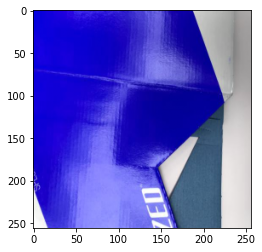

SOURCE: class: paper, file: paper\paper365.jpg
PREDICTED: class: glass, confidence: 0.278923


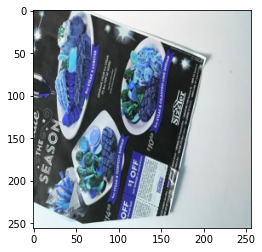

<Figure size 432x288 with 0 Axes>

SOURCE: class: plastic, file: plastic\plastic190.jpg
PREDICTED: class: paper, confidence: 0.953999


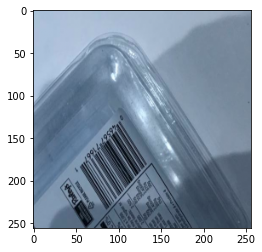

<Figure size 432x288 with 0 Axes>

SOURCE: class: glass, file: glass\glass292.jpg
PREDICTED: class: glass, confidence: 0.553845


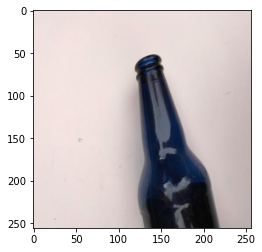

<Figure size 432x288 with 0 Axes>

SOURCE: class: metal, file: metal\metal70.jpg
PREDICTED: class: glass, confidence: 0.228950


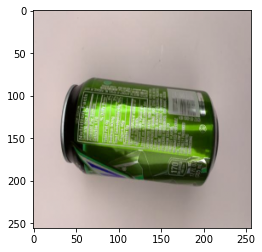

<Figure size 432x288 with 0 Axes>

SOURCE: class: plastic, file: plastic\plastic312.jpg
PREDICTED: class: plastic, confidence: 0.642051


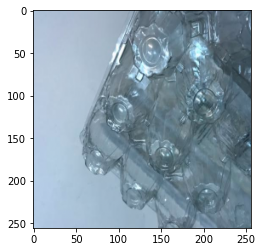

<Figure size 432x288 with 0 Axes>

SOURCE: class: glass, file: glass\glass267.jpg
PREDICTED: class: glass, confidence: 0.760860


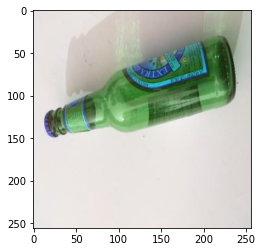

<Figure size 432x288 with 0 Axes>

SOURCE: class: metal, file: metal\metal296.jpg
PREDICTED: class: paper, confidence: 0.825445


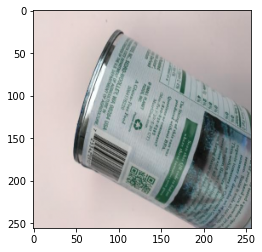

<Figure size 432x288 with 0 Axes>

SOURCE: class: metal, file: metal\metal347.jpg
PREDICTED: class: plastic, confidence: 0.641619


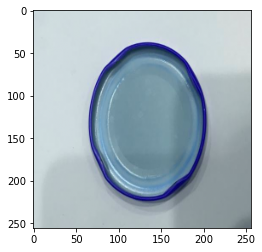

<Figure size 432x288 with 0 Axes>

In [128]:
for idx, filename in enumerate(random.sample(test_generator.filenames, 10)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [91]:
predict=classifier.predict_generator(test_generator)
# predict the class label
# y_classes = predict.argmax(axis=-1)

In [93]:
y_classes = predict.argmax(axis=-1)

In [94]:
len(y_classes)

1262

In [154]:
y_classes

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [173]:
classifier.save('model_test_v1.h5')

In [211]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [213]:
test_imgs, test_labels = next(test_generator)
# plots(test_imgs, titles=test_labels)
test_imgs

ValueError: not enough values to unpack (expected 2, got 1)

In [217]:
predictions=classifier.predict_generator(test_generator,steps=1,verbose=0)
predicted_classes = np.argmax(predictions, axis=1) 

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

In [210]:
predict

array([[0.1575426 , 0.1911274 , 0.16825701, 0.2293383 , 0.19057055,
        0.06316411]], dtype=float32)

In [206]:

confusion_matrix(test_generator.classes,y_predict)

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [183]:
from os import listdir
from os.path import isfile, join

classifier.load_weights("model_test_v1.h5")

file_path = "Recycling_Data\\test\\Test_Folder"
onlyfiles = [f for f in listdir(file_path) if isfile(join(file_path, f))]


In [181]:
from keras_preprocessing import image

test_dir

'Recycling_Data\\test'

In [195]:

for image_file in onlyfiles:
    print(image_file)
    img = image.load_img(file_path +"\\"+ image_file, target_size=(256, 256))
    x = image.img_to_array(img)
    x = x.reshape((1,)+x.shape)
    print(classifier.predict(x))
#     if classifier.predict(x) < 0.3:
#         print(image_file + ": Must be a cat")
#     if classifier.predict(x) > 0.7:
#         print(image_file + ": Must be a dog")
#     if classifier.predict(x) > 0.3 and model.predict(x) < 0.7:
#         print(image_file + ": Not sure if its a cat or a dog")

cardboard101.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
cardboard104.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
cardboard109.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
cardboard11.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
cardboard116.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
cardboard121.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
cardboard124.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
cardboard129.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
cardboard135.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
cardboard140.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
cardboard145.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
cardboard148.jpg
[[0.1575426  0.1911274  0.1

[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
glass447.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
glass450.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
glass453.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
glass455.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
glass459.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
glass46.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
glass461.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
glass466.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
glass468.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
glass470.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
glass472.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
glass48.jpg
[[0.15

[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
metal375.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
metal377.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
metal378.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
metal379.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
metal382.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
metal384.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
metal386.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
metal388.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
metal389.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
metal393.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
metal40.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
metal400.jpg
[[0.1

paper393.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
paper394.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
paper398.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
paper405.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
paper406.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
paper408.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
paper41.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
paper411.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
paper413.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
paper420.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
paper424.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
paper430.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
paper

[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
plastic209.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
plastic215.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
plastic218.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
plastic22.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
plastic221.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
plastic223.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
plastic226.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
plastic228.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
plastic234.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
plastic238.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
plastic248.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.0631641

[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
trash102.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
trash109.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
trash110.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
trash118.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
trash12.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
trash122.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
trash123.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
trash133.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
trash134.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
trash15.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
trash19.jpg
[[0.1575426  0.1911274  0.16825701 0.2293383  0.19057055 0.06316411]]
trash21.jpg
[[0.1575

array([3, 3], dtype=int64)

In [48]:
a = np.arange(6).reshape(2,3) + 10

In [49]:
a

array([[10, 11, 12],
       [13, 14, 15]])

In [55]:
np.argmax(a, axis=1)

array([2, 2], dtype=int64)

In [1]:
class_mapping = {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
class_mapping[0]

KeyError: 0